In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
campaign = pd.read_csv('~/Documents/appreciate/campaigns.csv')
campaign

ssb_campaign_uuid                                     name
0    06999d835967801342ac5e0138b30d6b            DT_DailyThemedCrossword_US_T1
1    c340be500e580ccc4452bcb470da4949             Playsimple-Word Trip-US-RTGT
2    cfbad4e5cdfcf8e68d0ff1ddb5135586     SingleTap_FB_ROW_Android_Video_FB_US
3    2359e9439151f256228cedd5f8780ed4   SingleTap_FB_ROW_Android_Display_FB_US
4    0c0ded719c3afb709b937d7a19e98991     Position Mobile - NewsHome - US - UA
..                                ...                                      ...
193  43242a117923679a04b02c58f671f1a8     SingleTap_FB_ROW_Android_Video_FB_MX
194  5c2cc36dc709f65250ad09e9926f2020   SmartNews_Cricket_SingleTap_All_CPI_V2
195  dad68c13e535c25d96b8a8af78f04033  SmartNews_Tracfone_SingleTap_All_CPI_V2
196  d71c42106c0bce1ab4ec672121dfe9a6             Stars Group-Poker Stars-BR-2
197  b8ccac17c71b8482cc92647a94577a57            Tiktok - TiktTok - MX - PR RT

[198 rows x 2 columns]

In [3]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [4]:
start_dt = '2021-04-17'
end_dt = '2021-05-17'

(1) What is CTI time? by experience (true GP, other GP, UA, preload RT)

(2) Revenue discrepancy between Via and BigQuery

In [5]:
df_stats = bigquery_client.query(f"""
select
    r.id
    , etimestamp
    , sp.bundle as sponsored_bnd
    , r.ssb_campaign_uuid
    , id.carrier
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(case when event_type = 'install' then revenue else 0 end) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
from stats.rows r
left join 
(
    select tid,max(carrier) as carrier
    from audiences.dt_aud
    group by 1
) id
    on r.tid = id.tid
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and ssb_buyer_id = 3549
    and left(r.id,2) = '00'
group by 1,2,3,4,5
""").to_dataframe()
df_stats = df_stats.set_index('ssb_campaign_uuid').join(campaign.set_index('ssb_campaign_uuid')).reset_index()
df_stats

ssb_campaign_uuid  \
0        0282f78e216dfd3118d71a5fe5ff49bf   
1        0282f78e216dfd3118d71a5fe5ff49bf   
2        0282f78e216dfd3118d71a5fe5ff49bf   
3        0282f78e216dfd3118d71a5fe5ff49bf   
4        0282f78e216dfd3118d71a5fe5ff49bf   
...                                   ...   
6091467  fe64a9f1d0e4986d64879d60781f14cf   
6091468  fe64a9f1d0e4986d64879d60781f14cf   
6091469  fe64a9f1d0e4986d64879d60781f14cf   
6091470  fe64a9f1d0e4986d64879d60781f14cf   
6091471  fe64a9f1d0e4986d64879d60781f14cf   

                                                        id  \
0        0059e075b3e86ad42b5b73163cc6671f046ccdc17d0906...   
1        00bc55fe557c2ba6a0538cc825224656e0a9fa82e9ceb4...   
2        006b96c379923f7c168f577bf5562b1707136a4bd0a64b...   
3        00143359594477f8b811f3bfd908cf6257c7625a0b324c...   
4        00d09e47430f7b8dc254150e1642db142a0abb4c3be0bf...   
...                                                    ...   
6091467  009835bafce842b215a8f5358e414a305cbeb9a9613721...   
6091468  0055028b4b6cf2cca876beb443b699fcbe2cb50046bd08...   
6091469  00253c3748f7788e478d1ad528a9487a9e43197ba76cc0...   
6091470  0097bea4c3f0a4f8710f1f1c19edcd37312ab68c80c905...   
6091471  00c0778d3eadcba984f13fab59dd1bf7fd6c748bb4b077...   

                       etimestamp               sponsored_bnd  carrier  \
0       2021-05-14 18:10:22+00:00         com.twitter.android     None   
1       2021-05-17 17:48:34+00:00         com.twitter.android     None   
2       2021-05-14 18:37:15+00:00         com.twitter.android     None   
3       2021-05-17 18:47:22+00:00         com.twitter.android     None   
4       2021-05-15 11:58:56+00:00         com.twitter.android     None   
...                           ...                         ...      ...   
6091467 2021-04-25 22:17:01+00:00  com.particlenews.newsbreak  cricket   
6091468 2021-05-09 13:57:24+00:00  com.particlenews.newsbreak  cricket   
6091469 2021-04-25 18:40:37+00:00  com.particlenews.newsbreak  cricket   
6091470 2021-04-22 16:20:05+00:00  com.particlenews.newsbreak  cricket   
6091471 2021-04-27 15:10:10+00:00  com.particlenews.newsbreak  cricket   

         impressions  clicks  installs  spend      cost  \
0                  1       0         0    0.0  0.000060   
1                  1       0         0    0.0  0.000060   
2                  0       1         0    0.0  0.000000   
3                  1       0         0    0.0  0.000060   
4                  1       0         0    0.0  0.000060   
...              ...     ...       ...    ...       ...   
6091467            1       0         0    0.0  0.001640   
6091468            1       0         0    0.0  0.005000   
6091469            1       0         0    0.0  0.001032   
6091470            1       0         0    0.0  0.003942   
6091471            1       0         0    0.0  0.008061   

                                                  name  
0                         Android-Twitter-Twitter-TR-4  
1                         Android-Twitter-Twitter-TR-4  
2                         Android-Twitter-Twitter-TR-4  
3                         Android-Twitter-Twitter-TR-4  
4                         Android-Twitter-Twitter-TR-4  
...                                                ...  
6091467  Particle Media - News Break - US - Cricket UA  
6091468  Particle Media - News Break - US - Cricket UA  
6091469  Particle Media - News Break - US - Cricket UA  
6091470  Particle Media - News Break - US - Cricket UA  
6091471  Particle Media - News Break - US - Cricket UA  

[6091472 rows x 11 columns]

In [6]:
df_stats[df_stats.ssb_campaign_uuid == 'b8ff657282f0dc915a97f582f69af0de'].groupby('carrier')['impressions','spend'].sum()

<ipython-input-6-8be72ff21960>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_stats[df_stats.ssb_campaign_uuid == 'b8ff657282f0dc915a97f582f69af0de'].groupby('carrier')['impressions','spend'].sum()


impressions  spend
carrier                       
acer                  5   0.00
amxapk               80   3.50
att                7500  77.05
blu                 119   0.00
cricket            3385  43.25
lenovo               18   0.00
millicom              7   0.00
pwg                   6   0.00
samsung             506   5.85
singtel               6   0.00
sliide               58   0.00
tracfone           4762  33.85
uscellular         1446  33.85
verizon            5704  63.05

In [7]:
df_installs = df_stats.loc[df_stats.installs > 0, ['id','etimestamp','installs','spend']].set_index('id')
df_clicks = df_stats.loc[df_stats.clicks > 0, ['id', 'etimestamp', 'clicks']].set_index('id')
df_impressions = df_stats.loc[df_stats.impressions > 0, ['id', 'sponsored_bnd', 'carrier', 'ssb_campaign_uuid', 'etimestamp', 'impressions', 'cost']].set_index('id')
df_stats[df_stats.spend > 0].pivot_table(values = ['impressions', 'clicks', 'installs'], index = 'sponsored_bnd', aggfunc = lambda x:len(x>0))

clicks  impressions  installs
sponsored_bnd                                                     
284035177                                54           54        54
air.com.playtika.slotomania               4            4         4
br.com.brainweb.ifood                    14           14        14
br.com.enjoei.app                        81           81        81
br.com.intermedium                       34           34        34
co.triller.droid                        118          118       118
com.affinity.rewarded_play               28           28        28
com.bbumgames.spadesroyale               29           29        29
com.bigrunstudios.blackoutblitz           9            9         9
com.booking                              61           61        61
com.creditsesame                         15           15        15
com.dd.doordash                          33           33        33
com.emn8.mobilem8.nativeapp.popeyes      88           88        88
com.facebook.katana                       2            2         2
com.home.news.breaking                   77           77        77
com.home.weather.radar                  732          732       732
com.huuuge.casino.texas                  26           26        26
com.innogames.foeandroid                 24           24        24
com.king.candycrushsaga                 338          338       338
com.kwai.video                          107          107       107
com.mars.avgchapters                     14           14        14
com.myklarnamobile                        1            1         1
com.opera.app.news                      103          103       103
com.pandora.android                     544          544       544
com.papaya.solitairecash                 24           24        24
com.particlenews.newsbreak             1793         1793      1793
com.pyrsoftware.pokerstars.com           29           29        29
com.ripio.android                       221          221       221
com.rovio.dream                          42           42        42
com.twitter.android                     309          309       309
com.weedmaps.app.android                 13           13        13
com.zhiliaoapp.musically                376          376       376
de.cellular.ottohybrid                    4            4         4
deezer.android.app                       33           33        33
in.crossy.daily_crossword                 7            7         7
in.playsimple.tripcross                 168          168       168
in.playsimple.wordtrip                  226          226       226
jp.gocro.smartnews.android              733          733       733
org.dayup.stocks                          1            1         1

In [8]:
df = df_impressions.join(df_clicks, how = 'left', lsuffix = '_imps', rsuffix = '_clicks')
df = df.join(df_installs, how = 'left', rsuffix = '_installs').reset_index()
df = df.set_index('ssb_campaign_uuid').join(campaign.set_index('ssb_campaign_uuid'), how = 'left').reset_index()
df.rename(columns = {'etimestamp':'etimestamp_installs'}, inplace = True)
df

ssb_campaign_uuid  \
0        0282f78e216dfd3118d71a5fe5ff49bf   
1        0282f78e216dfd3118d71a5fe5ff49bf   
2        0282f78e216dfd3118d71a5fe5ff49bf   
3        0282f78e216dfd3118d71a5fe5ff49bf   
4        0282f78e216dfd3118d71a5fe5ff49bf   
...                                   ...   
5001951  fe64a9f1d0e4986d64879d60781f14cf   
5001952  fe64a9f1d0e4986d64879d60781f14cf   
5001953  fe64a9f1d0e4986d64879d60781f14cf   
5001954  fe64a9f1d0e4986d64879d60781f14cf   
5001955  fe64a9f1d0e4986d64879d60781f14cf   

                                                        id  \
0        0000e8175efba6831a9d46ca50c15f8c3cd476c5ba203b...   
1        0000e8175efba6831a9d46ca50c15f8c62f85c74a8aeeb...   
2        0000e8175efba6831a9d46ca50c15f8cab9ba145ffebb7...   
3        0000e8175efba6831a9d46ca50c15f8ceba40b23048347...   
4        00014ab2be6bfa617ce0f0ad1cd104fb6def12a2e8f67d...   
...                                                    ...   
5001951  00ffe412ca618859ce424490300eb700679d5c7c00cf43...   
5001952  00ffe412ca618859ce424490300eb700867835a92650c3...   
5001953  00ffe412ca618859ce424490300eb700d242b28cbdae0a...   
5001954  00ffe412ca618859ce424490300eb700d88fc6e6ccc5a0...   
5001955  00ffe412ca618859ce424490300eb700e6021943d9ee22...   

                      sponsored_bnd  carrier           etimestamp_imps  \
0               com.twitter.android     None 2021-05-11 19:45:56+00:00   
1               com.twitter.android     None 2021-05-11 20:32:09+00:00   
2               com.twitter.android     None 2021-05-11 20:10:01+00:00   
3               com.twitter.android     None 2021-05-11 19:15:11+00:00   
4               com.twitter.android     None 2021-05-11 20:16:59+00:00   
...                             ...      ...                       ...   
5001951  com.particlenews.newsbreak  cricket 2021-05-03 01:53:04+00:00   
5001952  com.particlenews.newsbreak  cricket 2021-05-03 16:11:56+00:00   
5001953  com.particlenews.newsbreak     None 2021-04-19 21:59:15+00:00   
5001954  com.particlenews.newsbreak  cricket 2021-05-05 14:57:47+00:00   
5001955  com.particlenews.newsbreak     None 2021-04-19 23:11:50+00:00   

         impressions     cost         etimestamp_clicks  clicks  \
0                  1  0.00006                       NaT     NaN   
1                  1  0.00006                       NaT     NaN   
2                  1  0.00006                       NaT     NaN   
3                  1  0.00006                       NaT     NaN   
4                  1  0.00006 2021-05-11 20:18:11+00:00     1.0   
...              ...      ...                       ...     ...   
5001951            1  0.00277                       NaT     NaN   
5001952            1  0.00456                       NaT     NaN   
5001953            1  0.00500                       NaT     NaN   
5001954            1  0.00339 2021-05-05 14:58:06+00:00     1.0   
5001955            1  0.00500 2021-04-19 23:12:24+00:00     1.0   

        etimestamp_installs  installs  spend  \
0                       NaT       NaN    NaN   
1                       NaT       NaN    NaN   
2                       NaT       NaN    NaN   
3                       NaT       NaN    NaN   
4                       NaT       NaN    NaN   
...                     ...       ...    ...   
5001951                 NaT       NaN    NaN   
5001952                 NaT       NaN    NaN   
5001953                 NaT       NaN    NaN   
5001954                 NaT       NaN    NaN   
5001955                 NaT       NaN    NaN   

                                                  name  
0                         Android-Twitter-Twitter-TR-4  
1                         Android-Twitter-Twitter-TR-4  
2                         Android-Twitter-Twitter-TR-4  
3                         Android-Twitter-Twitter-TR-4  
4                         Android-Twitter-Twitter-TR-4  
...                                                ...  
5001951  Particle Media - News Break - US - Cricket UA  
5001952  Pa

In [9]:
df['name'] = df['name'].fillna(0)

exp_1 = [' rt','-rt',' pr','-pr',' retar','-retar','-1','- 1']
exp_2 = [' ua','-ua','-2','- 2']
exp_3 = [' gp','-gp','-3','- 3']
exp_4 = ['true gp','true-gp','true_gp','-4','- 4']

def classify_campaigns(r):
    if any(substr in str(r['name']).lower() for substr in exp_1):
        return 1
    elif any(substr in str(r['name']).lower() for substr in exp_4):
        return 4
    elif any(substr in str(r['name']).lower() for substr in exp_3):
        return 3
    elif any(substr in str(r['name']).lower() for substr in exp_2):
        return 2
    else:
        return np.nan
    
df['campaign_type'] = df.apply(lambda x:classify_campaigns(x), axis = 1)

In [10]:
df

ssb_campaign_uuid  \
0        0282f78e216dfd3118d71a5fe5ff49bf   
1        0282f78e216dfd3118d71a5fe5ff49bf   
2        0282f78e216dfd3118d71a5fe5ff49bf   
3        0282f78e216dfd3118d71a5fe5ff49bf   
4        0282f78e216dfd3118d71a5fe5ff49bf   
...                                   ...   
5001951  fe64a9f1d0e4986d64879d60781f14cf   
5001952  fe64a9f1d0e4986d64879d60781f14cf   
5001953  fe64a9f1d0e4986d64879d60781f14cf   
5001954  fe64a9f1d0e4986d64879d60781f14cf   
5001955  fe64a9f1d0e4986d64879d60781f14cf   

                                                        id  \
0        0000e8175efba6831a9d46ca50c15f8c3cd476c5ba203b...   
1        0000e8175efba6831a9d46ca50c15f8c62f85c74a8aeeb...   
2        0000e8175efba6831a9d46ca50c15f8cab9ba145ffebb7...   
3        0000e8175efba6831a9d46ca50c15f8ceba40b23048347...   
4        00014ab2be6bfa617ce0f0ad1cd104fb6def12a2e8f67d...   
...                                                    ...   
5001951  00ffe412ca618859ce424490300eb700679d5c7c00cf43...   
5001952  00ffe412ca618859ce424490300eb700867835a92650c3...   
5001953  00ffe412ca618859ce424490300eb700d242b28cbdae0a...   
5001954  00ffe412ca618859ce424490300eb700d88fc6e6ccc5a0...   
5001955  00ffe412ca618859ce424490300eb700e6021943d9ee22...   

                      sponsored_bnd  carrier           etimestamp_imps  \
0               com.twitter.android     None 2021-05-11 19:45:56+00:00   
1               com.twitter.android     None 2021-05-11 20:32:09+00:00   
2               com.twitter.android     None 2021-05-11 20:10:01+00:00   
3               com.twitter.android     None 2021-05-11 19:15:11+00:00   
4               com.twitter.android     None 2021-05-11 20:16:59+00:00   
...                             ...      ...                       ...   
5001951  com.particlenews.newsbreak  cricket 2021-05-03 01:53:04+00:00   
5001952  com.particlenews.newsbreak  cricket 2021-05-03 16:11:56+00:00   
5001953  com.particlenews.newsbreak     None 2021-04-19 21:59:15+00:00   
5001954  com.particlenews.newsbreak  cricket 2021-05-05 14:57:47+00:00   
5001955  com.particlenews.newsbreak     None 2021-04-19 23:11:50+00:00   

         impressions     cost         etimestamp_clicks  clicks  \
0                  1  0.00006                       NaT     NaN   
1                  1  0.00006                       NaT     NaN   
2                  1  0.00006                       NaT     NaN   
3                  1  0.00006                       NaT     NaN   
4                  1  0.00006 2021-05-11 20:18:11+00:00     1.0   
...              ...      ...                       ...     ...   
5001951            1  0.00277                       NaT     NaN   
5001952            1  0.00456                       NaT     NaN   
5001953            1  0.00500                       NaT     NaN   
5001954            1  0.00339 2021-05-05 14:58:06+00:00     1.0   
5001955            1  0.00500 2021-04-19 23:12:24+00:00     1.0   

        etimestamp_installs  installs  spend  \
0                       NaT       NaN    NaN   
1                       NaT       NaN    NaN   
2                       NaT       NaN    NaN   
3                       NaT       NaN    NaN   
4                       NaT       NaN    NaN   
...                     ...       ...    ...   
5001951                 NaT       NaN    NaN   
5001952                 NaT       NaN    NaN   
5001953                 NaT       NaN    NaN   
5001954                 NaT       NaN    NaN   
5001955                 NaT       NaN    NaN   

                                                  name  campaign_type  
0                         Android-Twitter-Twitter-TR-4            4.0  
1                         Android-Twitter-Twitter-TR-4            4.0  
2                         Android-Twitter-Twitter-TR-4            4.0  
3                         Android-Twitter-Twitter-TR-4            4.0  
4                         Android-Twitter-Twitter-TR-4            4.0  
...                                

In [11]:
df['ctit'] = df['etimestamp_installs']-df['etimestamp_clicks']
df['itit'] = df['etimestamp_installs']-df['etimestamp_imps']
df['install_type'] = np.where(~df['etimestamp_installs'].isna(), np.where(df['etimestamp_clicks'].isna(),'vt', 'ct'), '')
df.loc[df.install_type == 'vt', ['etimestamp_installs','etimestamp_clicks','etimestamp_imps','install_type','ctit','itit']]

etimestamp_installs etimestamp_clicks           etimestamp_imps  \
21692   2021-05-15 18:18:05+00:00               NaT 2021-05-15 18:16:54+00:00   
86344   2021-05-13 15:31:17+00:00               NaT 2021-05-13 00:14:44+00:00   
148479  2021-04-26 15:49:11+00:00               NaT 2021-04-26 15:15:01+00:00   
156148  2021-04-27 21:51:24+00:00               NaT 2021-04-26 23:28:29+00:00   
161381  2021-05-14 17:38:52+00:00               NaT 2021-05-14 16:30:59+00:00   
...                           ...               ...                       ...   
4817119 2021-05-04 13:55:35+00:00               NaT 2021-05-04 13:52:20+00:00   
4818163 2021-05-13 15:30:48+00:00               NaT 2021-05-12 22:47:32+00:00   
4915075 2021-05-18 00:11:41+00:00               NaT 2021-05-18 00:10:02+00:00   
4992512 2021-04-29 13:54:45+00:00               NaT 2021-04-28 23:07:05+00:00   
4997820 2021-05-04 11:34:47+00:00               NaT 2021-05-03 23:01:23+00:00   

        install_type ctit            itit  
21692             vt  NaT 0 days 00:01:11  
86344             vt  NaT 0 days 15:16:33  
148479            vt  NaT 0 days 00:34:10  
156148            vt  NaT 0 days 22:22:55  
161381            vt  NaT 0 days 01:07:53  
...              ...  ...             ...  
4817119           vt  NaT 0 days 00:03:15  
4818163           vt  NaT 0 days 16:43:16  
4915075           vt  NaT 0 days 00:01:39  
4992512           vt  NaT 0 days 14:47:40  
4997820           vt  NaT 0 days 12:33:24  

[694 rows x 6 columns]

(array([0.        , 0.00054645, 0.0010929 , 0.00218579, 0.00546448,
        0.01256831, 0.01584699, 0.00874317, 0.00655738, 0.00491803,
        0.00273224, 0.0010929 , 0.00163934, 0.0010929 , 0.0010929 ,
        0.00273224, 0.00163934, 0.00327869, 0.00163934, 0.00218579,
        0.0010929 , 0.00163934, 0.        , 0.00054645, 0.0010929 ,
        0.        , 0.00054645, 0.0010929 , 0.00163934, 0.00218579,
        0.00054645, 0.00327869, 0.        , 0.00054645, 0.0010929 ,
        0.00054645, 0.00054645, 0.00054645, 0.        , 0.00054645,
        0.00054645, 0.00054645, 0.        , 0.        , 0.        ,
        0.        , 0.0010929 , 0.        , 0.        , 0.        ,
        0.00054645, 0.0010929 , 0.        , 0.        , 0.        ,
        0.00054645, 0.        , 0.0010929 , 0.        , 0.        ]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 26

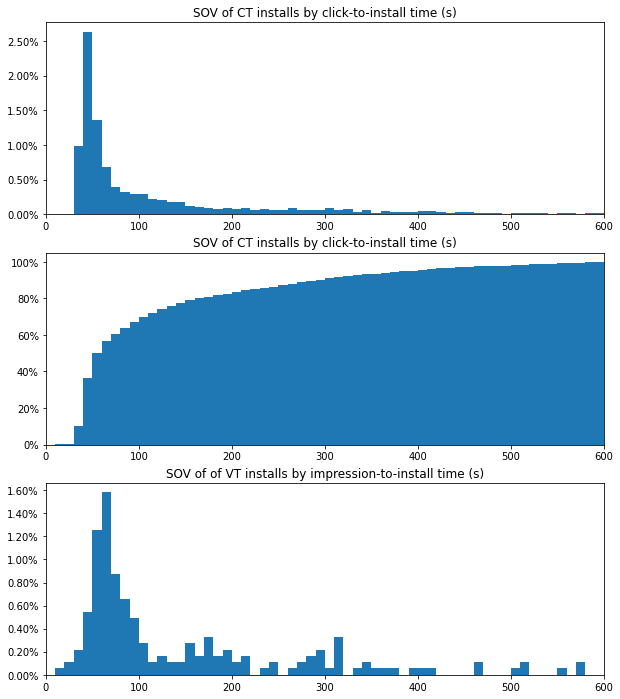

In [12]:
fig, ax = plt.subplots(3,1, figsize = (10,12))
ax[0].set_xlim(0,600)
ax[0].hist(df['ctit'].astype('timedelta64[s]'), range = (0,600), bins = 60, density = True, stacked = True)
ax[0].set_title('SOV of CT installs by click-to-install time (s)')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1].set_xlim(0,600)
ax[1].hist(df['ctit'].astype('timedelta64[s]'), range = (0,600), cumulative = True, bins = 60, density = True, stacked = True)
ax[1].set_title('SOV of CT installs by click-to-install time (s)')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[2].set_xlim(0,600)
ax[2].set_title('SOV of of VT installs by impression-to-install time (s)')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[2].hist(df.loc[df.install_type == 'vt', 'itit'].astype('timedelta64[s]'), range = (0,600), bins = 60, density= True)

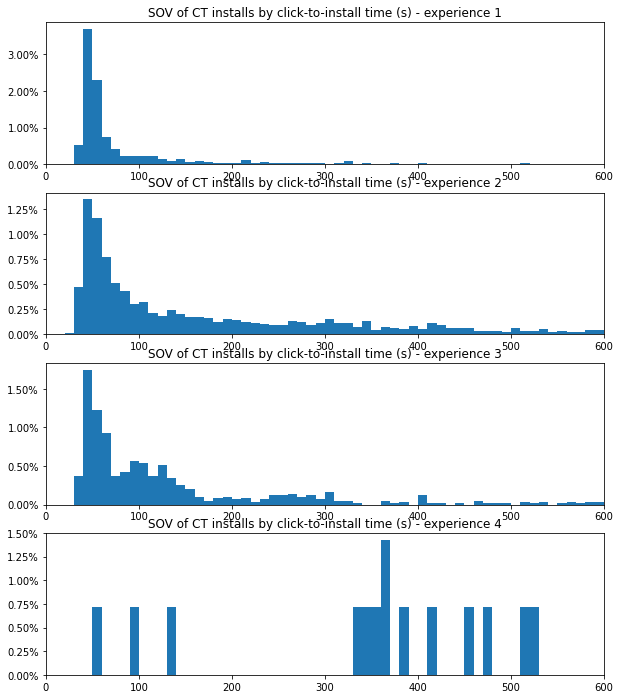

In [13]:
fig, ax = plt.subplots(4,1, figsize = (10,12))
ax[0].set_xlim(0,600)
ax[0].hist(df.loc[df.campaign_type == 1,'ctit'].astype('timedelta64[s]'), range = (0,600), bins = 60, density = True, stacked = True)
ax[0].set_title('SOV of CT installs by click-to-install time (s) - experience 1')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1].set_xlim(0,600)
ax[1].hist(df.loc[df.campaign_type == 2,'ctit'].astype('timedelta64[s]'), range = (0,600), bins = 60, density = True, stacked = True)
ax[1].set_title('SOV of CT installs by click-to-install time (s) - experience 2')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[2].set_xlim(0,600)
ax[2].hist(df.loc[df.campaign_type == 3,'ctit'].astype('timedelta64[s]'), range = (0,600), bins = 60, density = True, stacked = True)
ax[2].set_title('SOV of CT installs by click-to-install time (s) - experience 3')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[3].set_xlim(0,600)
ax[3].hist(df.loc[df.campaign_type == 4,'ctit'].astype('timedelta64[s]'), range = (0,600), bins = 60, density = True, stacked = True)
ax[3].set_title('SOV of CT installs by click-to-install time (s) - experience 4')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [14]:
df_stats.fillna(-1).groupby('carrier')['impressions','clicks','installs','spend','cost'].sum().sort_values('spend', ascending = False)

<ipython-input-14-7ffb5203b388>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_stats.fillna(-1).groupby('carrier')['impressions','clicks','installs','spend','cost'].sum().sort_values('spend', ascending = False)


impressions  clicks  installs    spend         cost
carrier                                                        
att              351798   13036      1544  3098.40  2443.257886
verizon          356230    7707      1142  3011.35  1711.060546
-1              3120984   77437       957  2100.80  3713.682404
tracfone         189064    6391       891  1436.05  1265.712974
amxapk           289568   23724       434   950.60   790.598696
cricket          170928    6477       530   879.30   783.523148
samsung          438765   22491       740   712.20   630.551333
uscellular        62128    1911       260   516.65   379.602673
blu                6274     378         7    18.25    15.238576
sliide             2405     108         7    13.00    11.873343
attmex             3891     312         2     2.70    13.971006
karbonn             337      10         1     1.16     0.269973
reliance             95       5         0     0.00     0.053125
tim                 683      10         0     0.00     0.245689
telefonica          354       5         0     0.00     0.062695
tcl                  29       1         0     0.00     0.060729
singtel             585      26         0     0.00     0.182800
millicom            476      15         0     0.00     0.707289
pwg                 147       5         0     0.00     0.223169
nokia                 2       0         0     0.00     0.002020
myphone              45       0         0     0.00     0.003856
acer                230       4         0     0.00     0.299146
lenovo             5189     210         0     0.00     6.492267
lava                347       8         0     0.00     0.327783
itel                507       7         0     0.00     0.261334
intex                 4       0         0     0.00     0.005772
globe               112       0         0     0.00     0.023841
archos                7       0         0     0.00     0.004163
zte                  81       4         0     0.00     0.188350

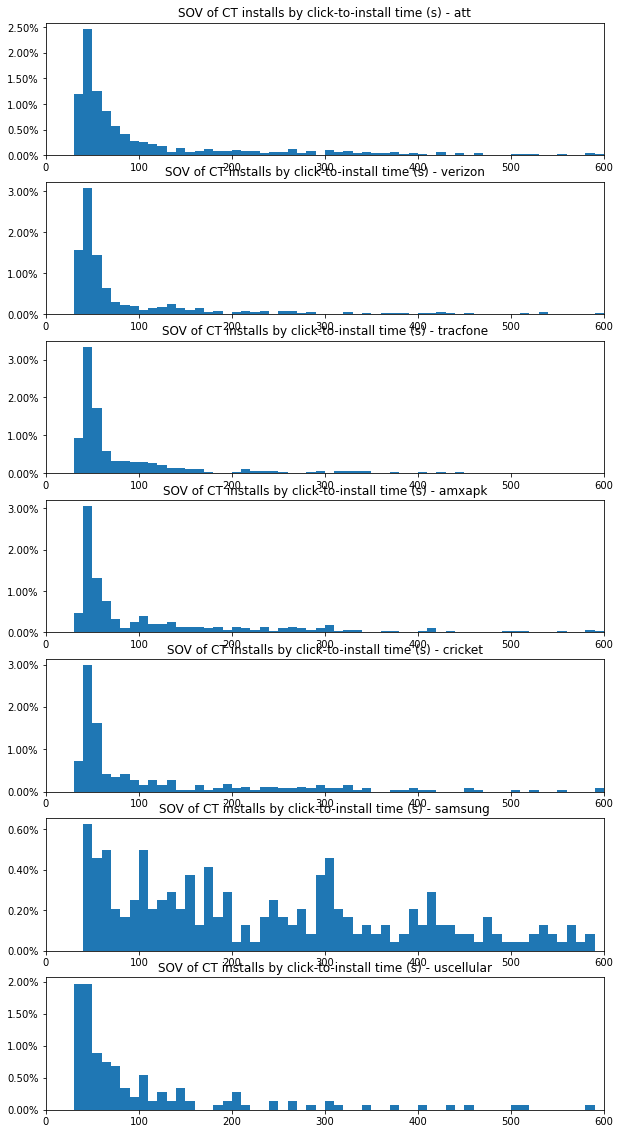

In [15]:
carrier_list = ['att','verizon','tracfone','amxapk','cricket','samsung','uscellular']
fig, ax = plt.subplots(7,1, figsize = (10,20))

for x in range(len(carrier_list)):
    ax[x].set_xlim(0,600)
    ax[x].hist(df.loc[df.carrier == carrier_list[x],'ctit'].astype('timedelta64[s]'), range = (0,600), bins = 60, density = True, stacked = True)
    ax[x].set_title(f'SOV of CT installs by click-to-install time (s) - {carrier_list[x]}')
    ax[x].yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [16]:
venus_query = f"""
select
    date(ef.event_timestamp) as dt
    , campaign_name
    , cd.app_identifier
    , sum(gross_revenue) spend
from venus.event_fact ef
join venus.campaign_dimension cd
    on ef.campaign_id = cd.campaign_id
join venus.partner_dimension pd
    on cd.partner_id = pd.partner_id      
where
    date(ef.event_timestamp) >= '{start_dt}'
    and date(ef.event_timestamp) <= '{end_dt}'
    and (
        lower(cd.campaign_name) like '%singletap%' 
        or lower(pd.partner_name) like '%singletap%'
        or lower(cd.campaign_name) like '%dsp%'
        or lower(cd.campaign_name) like '% ua%'
    )
group by 1,2,3
order by spend desc
;
"""

cur_olympus.execute(venus_query)
df_venus = pd.DataFrame(cur_olympus.fetchall(), columns = [c[0] for c in cur_olympus.description])

In [17]:
df_venus

dt                                      campaign_name  \
0     2021-05-14  DT - SingleTap - News Break - DSP - Non Preloa...   
1     2021-05-17  DT - SingleTap - News Break - DSP - Non Preloa...   
2     2021-05-15  DT - SingleTap - News Break - DSP - Non Preloa...   
3     2021-05-16  DT - SingleTap - News Break - DSP - Non Preloa...   
4     2021-05-13  DT - SingleTap - News Break - DSP - Non Preloa...   
...          ...                                                ...   
8105  2021-05-14  DT - SingleTap - DSP - PlaySimple - Word Wars ...   
8106  2021-05-15  DT - SingleTap - News Break - DataSeat - Non P...   
8107  2021-05-15  DT - SingleTap - Skillz - Blackout Blitz - Jum...   
8108  2021-05-15     DT - SingleTap - InMobi - Magic Jigsaw Puzzles   
8109  2021-05-15  DT - SingleTap - DSP - Skillz - Blackout Bingo...   

                       app_identifier       spend  
0          com.particlenews.newsbreak  25134.7500  
1          com.particlenews.newsbreak  23777.2500  
2          com.particlenews.newsbreak  23634.7500  
3          com.particlenews.newsbreak  23558.2500  
4          com.particlenews.newsbreak  22039.5000  
...                               ...         ...  
8105         com.littleengine.wordpal      0.0000  
8106       com.particlenews.newsbreak      0.0000  
8107  com.bigrunstudios.blackoutblitz      0.0000  
8108        com.bandagames.mpuzzle.gp      0.0000  
8109  com.bigrunstudios.blackoutblitz      0.0000  

[8110 rows x 4 columns]

In [18]:
df_apprec = bigquery_client.query(f"""
select
    date(etimestamp) as event_date
    , date(timestamp) as bid_date
    , sp.bundle as app_identifier
    , r.ssb_campaign_uuid
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
from stats.rows r
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and ssb_buyer_id = 3549
    and left(r.id,1) = '0'
group by 1,2,3,4
""").to_dataframe()
df_apprec = df_apprec.set_index('ssb_campaign_uuid').join(campaign.set_index('ssb_campaign_uuid')).reset_index()
df_apprec

ssb_campaign_uuid  event_date    bid_date  \
0      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-11  2021-05-11   
1      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-12  2021-05-11   
2      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-17  2021-05-15   
3      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-13  2021-05-12   
4      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-14  2021-05-13   
...                                 ...         ...         ...   
10224  fe64a9f1d0e4986d64879d60781f14cf  2021-04-25  2021-04-24   
10225  fe64a9f1d0e4986d64879d60781f14cf  2021-05-11  2021-05-11   
10226  fe64a9f1d0e4986d64879d60781f14cf  2021-05-05  2021-05-05   
10227  fe64a9f1d0e4986d64879d60781f14cf  2021-05-02  2021-04-29   
10228  fe64a9f1d0e4986d64879d60781f14cf  2021-04-22  2021-04-21   

                   app_identifier  installs  spend  \
0             com.twitter.android         0    0.0   
1             com.twitter.android         0    0.0   
2             com.twitter.android         0    0.0   
3             com.twitter.android         0    0.0   
4             com.twitter.android         0    0.0   
...                           ...       ...    ...   
10224  com.particlenews.newsbreak        80   80.0   
10225  com.particlenews.newsbreak       192  192.0   
10226  com.particlenews.newsbreak       496  496.0   
10227  com.particlenews.newsbreak         0    0.0   
10228  com.particlenews.newsbreak        48   48.0   

                                                name  
0                       Android-Twitter-Twitter-TR-4  
1                       Android-Twitter-Twitter-TR-4  
2                       Android-Twitter-Twitter-TR-4  
3                       Android-Twitter-Twitter-TR-4  
4                       Android-Twitter-Twitter-TR-4  
...                                              ...  
10224  Particle Media - News Break - US - Cricket UA  
10225  Particle Media - News Break - US - Cricket UA  
10226  Particle Media - News Break - US - Cricket UA  
10227  Particle Media - News Break - US - Cricket UA  
10228  Particle Media - News Break - US - Cricket UA  

[10229 rows x 7 columns]

In [19]:
df_apprec['app_identifier'] = df_apprec['app_identifier'].str.replace('284035177','com.pandora.android')
df_apprec['app_identifier'] = df_apprec['app_identifier'].str.replace('1132762804','com.particlenews.newsbreak')
df_apprec

ssb_campaign_uuid  event_date    bid_date  \
0      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-11  2021-05-11   
1      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-12  2021-05-11   
2      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-17  2021-05-15   
3      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-13  2021-05-12   
4      0282f78e216dfd3118d71a5fe5ff49bf  2021-05-14  2021-05-13   
...                                 ...         ...         ...   
10224  fe64a9f1d0e4986d64879d60781f14cf  2021-04-25  2021-04-24   
10225  fe64a9f1d0e4986d64879d60781f14cf  2021-05-11  2021-05-11   
10226  fe64a9f1d0e4986d64879d60781f14cf  2021-05-05  2021-05-05   
10227  fe64a9f1d0e4986d64879d60781f14cf  2021-05-02  2021-04-29   
10228  fe64a9f1d0e4986d64879d60781f14cf  2021-04-22  2021-04-21   

                   app_identifier  installs  spend  \
0             com.twitter.android         0    0.0   
1             com.twitter.android         0    0.0   
2             com.twitter.android         0    0.0   
3             com.twitter.android         0    0.0   
4             com.twitter.android         0    0.0   
...                           ...       ...    ...   
10224  com.particlenews.newsbreak        80   80.0   
10225  com.particlenews.newsbreak       192  192.0   
10226  com.particlenews.newsbreak       496  496.0   
10227  com.particlenews.newsbreak         0    0.0   
10228  com.particlenews.newsbreak        48   48.0   

                                                name  
0                       Android-Twitter-Twitter-TR-4  
1                       Android-Twitter-Twitter-TR-4  
2                       Android-Twitter-Twitter-TR-4  
3                       Android-Twitter-Twitter-TR-4  
4                       Android-Twitter-Twitter-TR-4  
...                                              ...  
10224  Particle Media - News Break - US - Cricket UA  
10225  Particle Media - News Break - US - Cricket UA  
10226  Particle Media - News Break - US - Cricket UA  
10227  Particle Media - News Break - US - Cricket UA  
10228  Particle Media - News Break - US - Cricket UA  

[10229 rows x 7 columns]

In [20]:
df_apprec_event_dt = df_apprec.groupby(['ssb_campaign_uuid','name','app_identifier','event_date'])['installs','spend'].sum().reset_index()
df_apprec_bid_dt = df_apprec.groupby(['ssb_campaign_uuid','name','app_identifier','bid_date'])['installs','spend'].sum().reset_index()
df_apprec_bnd_event_dt = df_apprec.groupby(['app_identifier','event_date'])['installs','spend'].sum().reset_index()
df_apprec_bnd_bid_dt = df_apprec.groupby(['app_identifier','bid_date'])['installs','spend'].sum().reset_index()

df_venus_bnd = df_venus.groupby(['app_identifier','dt'])['spend'].sum().to_frame().reset_index()
df_venus_bnd

<ipython-input-20-a69308aaa66c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_apprec_event_dt = df_apprec.groupby(['ssb_campaign_uuid','name','app_identifier','event_date'])['installs','spend'].sum().reset_index()
<ipython-input-20-a69308aaa66c>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_apprec_bid_dt = df_apprec.groupby(['ssb_campaign_uuid','name','app_identifier','bid_date'])['installs','spend'].sum().reset_index()
<ipython-input-20-a69308aaa66c>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_apprec_bnd_event_dt = df_apprec.groupby(['app_identifier','event_date'])['installs','spend'].sum().reset_index()
<ipython-input-20-a69308aaa66c>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will

app_identifier          dt   spend
0     air.com.buffalo_studios.newflashbingo  2021-04-18  0.0000
1     air.com.buffalo_studios.newflashbingo  2021-05-05  0.0000
2     air.com.buffalo_studios.newflashbingo  2021-05-06  0.0000
3     air.com.buffalo_studios.newflashbingo  2021-05-10  0.0000
4     air.com.buffalo_studios.newflashbingo  2021-05-11  0.0000
...                                     ...         ...     ...
4283                     us.current.android  2021-05-09  0.0000
4284                     us.current.android  2021-05-10  0.0000
4285                     us.current.android  2021-05-12  0.0000
4286                     us.current.android  2021-05-15  0.0000
4287                     us.current.android  2021-05-17  0.0000

[4288 rows x 3 columns]

In [21]:
merged_bnd_event_dt = pd.merge(df_venus_bnd, df_apprec_bnd_event_dt
                               , left_on = ['app_identifier','dt'], right_on = ['app_identifier','event_date']
                              , suffixes = ['_dt','_apprec'], how = 'outer')
merged_bnd_event_dt['spend_dt'] = merged_bnd_event_dt['spend_dt'].astype(float)

merged_bnd = merged_bnd_event_dt.groupby('app_identifier')['spend_dt','spend_apprec'].sum()
merged_bnd['pct_diff'] = 100*merged_bnd['spend_dt']/merged_bnd['spend_apprec']-100
merged_bnd.sort_values('spend_apprec', ascending = False, inplace = True)

format_mapping = {'spend_dt':'${:,.0f}'
                 ,'spend_apprec':'${:,.0f}'
                 ,'pct_diff':'{0:.0f}%'}
print(merged_bnd.sum())
merged_bnd[(merged_bnd.spend_apprec > 0)].style.format(format_mapping).background_gradient(cmap=cm, axis = 0, subset = ['pct_diff'])

spend_dt        3380671.21
spend_apprec    3224927.20
pct_diff               inf
dtype: float64


<ipython-input-21-e68e5f541f79>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_bnd = merged_bnd_event_dt.groupby('app_identifier')['spend_dt','spend_apprec'].sum()


In [22]:
merged_bnd_bid_dt = pd.merge(df_venus_bnd, df_apprec_bnd_bid_dt
                               , left_on = ['app_identifier','dt'], right_on = ['app_identifier','bid_date']
                              , suffixes = ['_dt','_apprec'], how = 'outer')
merged_bnd_bid_dt['spend_dt'] = merged_bnd_bid_dt['spend_dt'].astype(float)

merged_bnd = merged_bnd_bid_dt.groupby('app_identifier')['spend_dt','spend_apprec'].sum()
merged_bnd['pct_diff'] = 100*merged_bnd['spend_dt']/merged_bnd['spend_apprec']-100
merged_bnd.sort_values('spend_apprec', ascending = False, inplace = True)

format_mapping = {'spend_dt':'${:,.0f}'
                 ,'spend_apprec':'${:,.0f}'
                 ,'pct_diff':'{0:.0f}%'}
merged_bnd[(merged_bnd.spend_apprec > 0)].style.format(format_mapping).background_gradient(cmap=cm, axis = 0, subset = ['pct_diff'])

<ipython-input-22-22d423a16e04>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_bnd = merged_bnd_bid_dt.groupby('app_identifier')['spend_dt','spend_apprec'].sum()


In [23]:
merged_bnd.sum()

spend_dt        3380671.21
spend_apprec    3224927.20
pct_diff               inf
dtype: float64

Text(0.5, 1.0, 'Percent difference between DT and Apprec spend, by application')

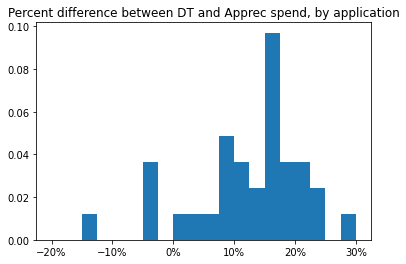

In [24]:
plt.hist(merged_bnd['pct_diff'], range = (-20,30), bins = 20, stacked = True, density = True)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percent difference between DT and Apprec spend, by application')

In [25]:
merged_bid_dt = pd.merge(df_venus, df_apprec_bid_dt, left_on = ['campaign_name', 'dt'], right_on = ['name', 'bid_date'], how = 'inner', suffixes = ['_venus', '_apprec'])
merged_bid_dt['spend_variance'] = (merged_event_dt['spend_venus'].astype('float')/merged_event_dt['spend_apprec'])-1
plt.hist(merged_bid_dt['spend_variance'], range = (-2,2), bins = 50, stacked = True, density = True)

NameError: name 'merged_event_dt' is not defined